### **Physics-Informed Neural Network (PINN) para aproximar una Ecuación Diferencial.**

*José Luis Sánchez Soto A01802409*

**¿Qué es una PINN?**

Una Physics-Informed Neural Network (PINN) es una red neuronal que aprende a resolver ecuaciones diferenciales incorporando la física dentro de la función de pérdida.

**¿En qué se diferencia una PINN de una red neuronal tradicional?**

Una red neuronal tradicional aprende a partir de datos etiquetados. Es decir, necesita pares de entrada–salida (x,y) para ajustar sus parámetros y minimizar un error entre sus predicciones y los datos reales.

En cambio, una Physics-Informed Neural Network (PINN) no depende únicamente de datos. Su entrenamiento incorpora directamente las leyes físicas del problema, representadas por la ecuación diferencial.
Esto significa que la función de pérdida incluye el residuo de la ecuación diferencial, asegurando que la solución aprendida cumpla con la física del sistema.

**Ecuación diferencial a resolver:**

$y' = e^{x+y}, \quad y(0) = -1$

**Resolviendo analíticamente:**

$y = -\ln\left(e + 1 - e^{x}\right)$



**Nota:** Durante la ejecución pueden aparecer warnings relacionados con CUDA/cuDNN y protobuf en el entorno de Kaggle.  
Estos no afectan el entrenamiento ni los resultados del modelo.

In [1]:
# Importamos las líbrerias necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2025-12-15 19:07:04.994997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765825625.241213      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765825625.332397      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Para empezar primero importamos las librerías que vamos a utilizar:
- **TensorFlow**: Para crear y entrenar la red neuronal
- **NumPy**: Para cálculos numéricos
- **Matplotlib**: Para visualizar resultados

In [2]:
# Definimos la solución exacta para compararla después
def exact_solution(x):
    return -np.log(np.e + 1 - np.exp(x))

# Probamos la solución exacta en algunos puntos
x_test = np.array([0.0, 0.5, 1.0])
y_exact = exact_solution(x_test)
print("Solución exacta en algunos puntos:")
for i in range(len(x_test)):
    print(f"x = {x_test[i]:.1f}, y = {y_exact[i]:.4f}")

Solución exacta en algunos puntos:
x = 0.0, y = -1.0000
x = 0.5, y = -0.7273
x = 1.0, y = -0.0000


**Solución Exacta**

Definimos la solución analítica conocida para poder comparar con los resultados de nuestra red neuronal. Esto nos permite validar que la PINN está aprendiendo correctamente.

In [3]:
# Creamos la red neuronal
def create_simple_nn():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,)),
        tf.keras.layers.Dense(20, activation='tanh'),
        tf.keras.layers.Dense(20, activation='tanh'),
        tf.keras.layers.Dense(1)])
    return model

model = create_simple_nn()
print("Red neuronal creada:")
model.summary()

Red neuronal creada:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-15 19:07:23.176145: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901 (3.52 KB)

 Trainable params: 901 (3.52 KB)

 Non-trainable params: 0 (0.00 B)

**Arquitectura de la Red Neuronal:**

Creamos una red neuronal fully-connected (densa) con:
- **1 neurona de entrada** (el valor de x)
- **3 capas ocultas** con 20 neuronas cada una
- **1 neurona de salida** (la predicción de y(x))

Usamos **tanh** como la función de activación porque es suave y diferenciable, lo cual es importante para calcular derivadas.

In [4]:
# Función de pérdida que incorpora la física
def physics_loss(x, model):

    #Calcula la pérdida física: cuánto se viola la ecuación diferencial
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model(x)
    
    # Calcular derivada dy/dx usando Automatic Differentiation
    dy_dx = tape.gradient(y_pred, x)
    
    # Ecuación diferencial: y' = e^(x+y)
    # Queremos que: dy_dx - e^(x+y) = 0
    diff_eq_loss = dy_dx - tf.exp(x + y_pred)
    
    # Pérdida como error cuadrático medio
    return tf.reduce_mean(tf.square(diff_eq_loss))

def initial_condition_loss(model):

    #Pérdida por condición inicial: y(0) debería ser -1
    x0 = tf.constant([[0.0]])  # x = 0
    y0_pred = model(x0)
    y0_true = tf.constant([[-1.0]])  # y(0) = -1
    return tf.reduce_mean(tf.square(y0_pred - y0_true))

def total_loss(x, model):
    
    #Pérdida total = Pérdida física + Pérdida condición inicial
    loss_physics = physics_loss(x, model)
    loss_initial = initial_condition_loss(model)
    return loss_physics + loss_initial

print("Funciones de pérdida definidas")

Funciones de pérdida definidas


**La Pérdida Física**

En una red neuronal normal, solo tenemos datos de entrada y salida. En una PINN, incorporamos la ecuación diferencial directamente en la función de pérdida:

1. **Pérdida Física**: Medimos cuánto viola nuestra solución la ecuación diferencial
   $\text{loss}_\text{physics} = \left(\frac{dy}{dx} - e^{(x+y)}\right)^2$

2. **Pérdida Condición Inicial**: Aseguramos que $y(0) = -1$

3. **Pérdida Total**: Suma de ambas pérdidas

Usamos `GradientTape` de TensorFlow para calcular las derivadas automáticamente.

In [5]:
# Entrenar la PINN
def train_pinn(model, epochs=3000, learning_rate=0.001):
    
    # Entrena la PINN usando el optimizador Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    # Puntos de entrenamiento en el dominio [0, 1]
    x_train = tf.constant(np.random.rand(1000, 1), dtype=tf.float32)
    
    # Historial de pérdidas
    losses = []
    
    print("Comenzando el entrenamiento...")
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = total_loss(x_train, model)
        
        # Calcular los gradientes y actualizar pesos
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        losses.append(loss.numpy())
        
        if epoch % 250 == 0:
            print(f"Época {epoch}: Pérdida = {loss.numpy():.6f}")
    
    return losses

# Entrenar el modelo
losses = train_pinn(model)
print("Entrenamiento completado")

Comenzando el entrenamiento...
Época 0: Pérdida = 4.514617
Época 250: Pérdida = 0.059837
Época 500: Pérdida = 0.034387
Época 750: Pérdida = 0.017338
Época 1000: Pérdida = 0.013064
Época 1250: Pérdida = 0.007446
Época 1500: Pérdida = 0.001328
Época 1750: Pérdida = 0.000390
Época 2000: Pérdida = 0.000278
Época 2250: Pérdida = 0.000226
Época 2500: Pérdida = 0.000189
Época 2750: Pérdida = 0.000158
Entrenamiento completado


**Proceso de Entrenamiento**

Entrenamos la red neuronal minimizando la pérdida total:
- **Optimizador**: Adam (eficiente para redes neuronales)
- **Tasa de aprendizaje**: 0.001
- **Épocas**: 3000 iteraciones
- **Puntos de entrenamiento**: 1000 puntos aleatorios en [0, 1]

En cada época:
1. Calculamos la pérdida total
2. Calculamos gradientes con `GradientTape`
3. Actualizamos los pesos de la red

In [6]:
# Evaluar y comparar con solución exacta

# Generar puntos de prueba
x_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Predicciones de la PINN
y_pred = model.predict(x_test)

# Solución exacta
y_exact = exact_solution(x_test)

# Calcular el error
error = np.abs(y_pred - y_exact)
max_error = np.max(error)
mean_error = np.mean(error)

print("Resultados:")
print(f"Error máximo: {max_error:.6f}")
print(f"Error medio: {mean_error:.6f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Resultados:
Error máximo: 0.003923
Error medio: 0.001936


**Evaluación de Resultados**

Generamos predicciones en 100 puntos equiespaciados y comparamos con la solución exacta:

- **Error máximo**: Peor caso de aproximación
- **Error medio**: Error promedio en todo el dominio

Estas métricas nos dicen qué tan bien aprendió la PINN a resolver la ecuación diferencial.

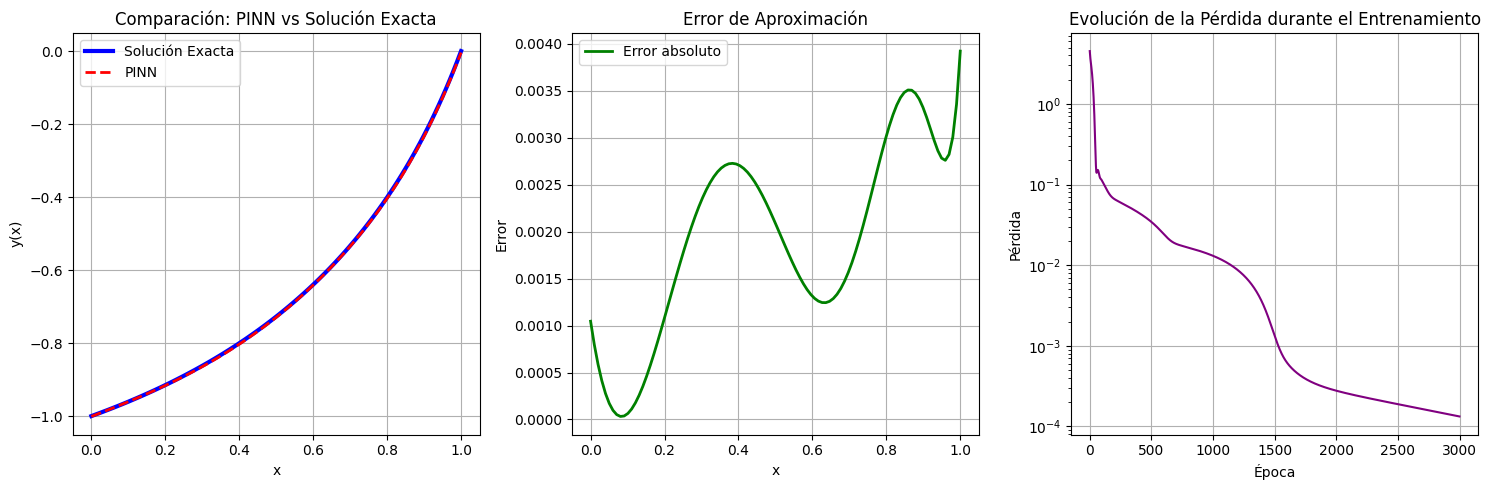

In [7]:
# Gráficas para comparar resultados
plt.figure(figsize=(15, 5))

# Gráfica 1: Soluciones
plt.subplot(1, 3, 1)
plt.plot(x_test, y_exact, 'b-', label='Solución Exacta', linewidth=3)
plt.plot(x_test, y_pred, 'r--', label='PINN', linewidth=2)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Comparación: PINN vs Solución Exacta')
plt.legend()
plt.grid(True)

# Gráfica 2: Error
plt.subplot(1, 3, 2)
plt.plot(x_test, error, 'g-', label='Error absoluto', linewidth=2)
plt.xlabel('x')
plt.ylabel('Error')
plt.title('Error de Aproximación')
plt.legend()
plt.grid(True)

# Gráfica 3: Evolución de la pérdida
plt.subplot(1, 3, 3)
plt.plot(losses, 'purple')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.yscale('log')  # Escala logarítmica para ver mejor la convergencia
plt.grid(True)

plt.tight_layout()
plt.show()

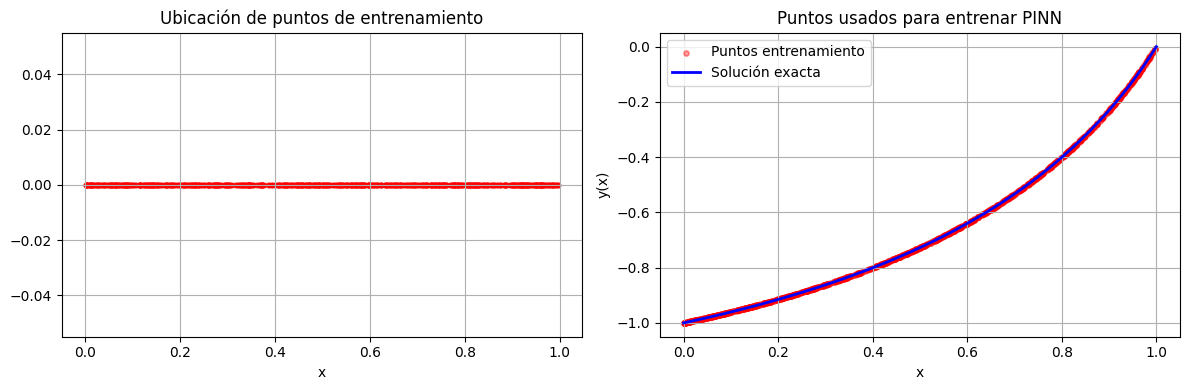

In [8]:
# Graficar puntos de entrenamiento
plt.figure(figsize=(12, 4))

# Puntos de entrenamiento
x_train_vis = np.random.rand(1000, 1)
y_train_vis = exact_solution(x_train_vis)

plt.subplot(1, 2, 1)
plt.scatter(x_train_vis, np.zeros_like(x_train_vis), alpha=0.6, color='red', s=10)
plt.xlabel('x')
plt.title('Ubicación de puntos de entrenamiento')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x_train_vis, y_train_vis, alpha=0.4, color='red', s=15, label='Puntos entrenamiento')
plt.plot(x_test, y_exact, 'b-', linewidth=2, label='Solución exacta')
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Puntos usados para entrenar PINN')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Resultados y Conclusiones:**

Los resultados muestran que la PINN es capaz de aproximar con alta precisión la solución analítica del sistema, presentando una superposición casi exacta entre la predicción de la red y la solución cerrada. La evolución de la función de pérdida evidencia una convergencia estable durante el entrenamiento, mientras que el análisis del error absoluto confirma que la red mantiene discrepancias pequeñas y acotadas en todo el dominio evaluado.

Estos hallazgos demuestran la eficacia de las PINNs para resolver ecuaciones diferenciales incluso sin datos experimentales, aprovechando directamente la estructura matemática del problema. La metodología utilizada constituye una base sólida para extender este enfoque hacia ecuaciones diferenciales más complejas, sistemas de EDOs o incluso ecuaciones en derivadas parciales, resaltando el potencial de las PINNs como herramienta computacional moderna en la modelación científica.